In [1]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

from datasets import load_dataset
import pandas as pd
from datasets import ClassLabel
import psutil
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
import numpy as np
from IPython.display import clear_output
import re

import model.fasttext_np as fasttext
import src.model.tokenizer as tokenizer

/mnt/c/Users/ASUS/Documents/GitHub/stop_slop/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("elalber2000/stop-slop-data")["train"]
ds = ds.rename_columns({
    "content": "text",
})

def binarize(example):
    example['label'] = {"Non-Slop": 0, "Slop": 1}[example['slop']]
    return example

ds = ds.map(binarize)

features = ds.features.copy()
features["label"] = ClassLabel(names=["Non-Slop", "Slop"])
ds = ds.cast(features)

In [3]:
splits = ds.train_test_split(
    test_size=0.2,
    stratify_by_column="label",
    seed=42
)
train_ds, val_ds = splits["train"], splits["test"]

In [4]:
# Memory Availability

mem = psutil.virtual_memory()
print(f"Available memory: {mem.available / (1024**2):.2f} MB")
print(f"Total memory: {mem.total / (1024**2):.2f} MB")
print(f"Used memory: {(mem.total - mem.available) / (1024**2):.2f} MB")

Available memory: 1633.66 MB
Total memory: 2987.68 MB
Used memory: 1354.02 MB


In [5]:
import re, html

URL_RE            = re.compile(r'https?://\S+|www\.\S+')
MAIL_RE           = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b')
NUM_RE            = re.compile(r'\b\d+(?:[\.,]\d+)*\b')
UUID_RE   = re.compile(r'\b[0-9a-fA-F]{8}-[0-9a-fA-F]{4}-'
                       r'[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-'
                       r'[0-9a-fA-F]{12}\b')
HEX_RE    = re.compile(r'\b0x[0-9A-Fa-f]+\b|\b[0-9A-Fa-f]{6,}\b')
SKU_RE    = re.compile(r'\b[A-Z]{2,5}[-_]\d{3,6}\b')
INVOICE_RE  = re.compile(r'\b(?:INV|ORD|TXN)\d{4,8}\b')
SLUG_RE   = re.compile(r'\b(?=[A-Za-z0-9]*[A-Za-z])(?=[A-Za-z0-9]*\d)'
                       r'[A-Za-z0-9]{8,}\b')
ID_RE     = re.compile(r'\b(?=[A-Za-z0-9]*[A-Za-z])(?=[A-Za-z0-9]*\d)'
                       r'[A-Za-z0-9]{4,}\b')
ISO_RE            = re.compile(r'\b\d{4}-\d{2}-\d{2}[tT]\d{2}:\d{2}:\d{2}(?:\.\d+)?Z\b')
WS_RE             = re.compile(r'\s+')
BLOCK_RE          = re.compile(r'(?is)<(script|style|template|noscript)[\s>][^>]*>.*?</\1\s*>')
TAG_RE            = re.compile(r'(?s)</?([A-Za-z][\w:-]*)[^>]*?>')
LEN_RE            = re.compile(r'(?i)\b(?:[a-z]{1,3}|[a-z]{11,})\b')
SUFFIX_RE         = re.compile(r'(?i)\b[a-z]*(?:ing|ers?)\b')
COMMENT_RE        = re.compile(r'(?s)<!--.*?-->')
ALT_TITLE_RE      = re.compile(r'(?i)\b(?:alt|title)\s*=\s*"([^"]*)"')
STOP_TRIGRAM_RE   = re.compile(r'(?i)\b[a-z]*(?:hat|tha|nth|tth|sth)[a-z]*\b')

def preprocess_fn(text: str) -> str:
    text = BLOCK_RE.sub(lambda m: f' __tag_{m.group(1).lower()}__ ', text)
    text = TAG_RE.sub   (lambda m: f' __tag_{m.group(1).lower()}__ ', text)

    text = html.unescape(text)

    text = URL_RE.sub(' __url__ ',  text)
    text = MAIL_RE.sub(' __email__ ', text)
    text = ISO_RE.sub(' __iso_date__ ', text)
    text = NUM_RE.sub(' __num__ ', text)
    text = UUID_RE.sub(' __uuid__ ', text)
    text = HEX_RE.sub(' __hex__ ', text)
    text = SKU_RE.sub(' __sku__ ', text)
    text = INVOICE_RE.sub(' __invoice__ ', text)
    text = SLUG_RE.sub(' __slug__ ', text)
    text = ID_RE.sub(' __id__ ', text)

    text = LEN_RE.sub(' ', text)
    text = SUFFIX_RE.sub('', text)
    text = COMMENT_RE.sub(' ', text)
    text =  ALT_TITLE_RE.sub(' ', text)
    text = STOP_TRIGRAM_RE.sub(' ', text)

    text = WS_RE.sub(' ', text).lower().strip()
    return text



tok = tokenizer.FastTextTokenizer(
    bucket_size=int(5e5),
    ngram_size=(4, 5),
    min_subword_freq=10,
    max_token=200,
    preprocess_fn=preprocess_fn,
)
tok.build_subword_mask([ex["text"] for ex in train_ds])

ft = fasttext.FastTextModel(
    num_class=2,
    lr=0.05,
    emb_size=100,
    batch_size=32,
    bucket_size=int(5e5),
    dropout_rate=0.1,
    reg_lambda=1e-4,
)

2025-05-12 20:09:46,655 [INFO] Initializing config
2025-05-12 20:09:46,688 [INFO] Initializing parameters
2025-05-12 20:09:48,657 [INFO] Initializing vals


In [6]:
train_texts = [ex["text"] for ex in train_ds]
train_labels = np.array([ex["label"] for ex in train_ds])
train_tokens = tok.batch_encode(train_texts)

val_texts   = [ex["text"] for ex in val_ds]
val_labels  = np.array([ex["label"] for ex in val_ds])
val_tokens  = tok.batch_encode(val_texts)

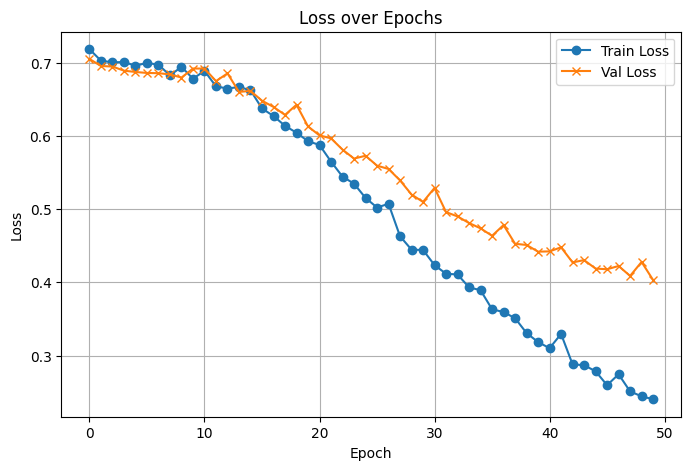

Epoch 50: train=0.2404, val=0.4032


In [7]:
N_EPOCH = 50
train_losses, val_losses = [], []

for epoch in range(1, N_EPOCH + 1):
    perm = np.random.permutation(len(train_tokens))
    epoch_losses = []

    for i in range(0, len(perm), ft.batch_size):
        batch_idx    = perm[i : i + ft.batch_size]
        batch_toks   = [train_tokens[j] for j in batch_idx]
        batch_lbls   = train_labels[batch_idx]
        batch_df     = pd.DataFrame({"text": batch_toks, "label": batch_lbls})

        ft.backward(batch_df)
        epoch_losses.append(ft._loss_vals[-1])

    avg_train = float(np.mean(epoch_losses))
    train_losses.append(avg_train)

    val_df = pd.DataFrame({"text": val_tokens, "label": val_labels})
    vloss  = ft.eval(val_df)
    val_losses.append(vloss)

    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, marker='o', label='Train Loss')
    plt.plot(val_losses,   marker='x', label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Epoch {epoch:2d}: train={avg_train:.4f}, val={vloss:.4f}")

In [8]:
from collections import defaultdict
import math
import pandas as pd
from tqdm import tqdm

w_diff = ft.weights[:,1] - ft.weights[:,0]
ngram_raw = defaultdict(list)
word_agg = defaultdict(lambda: [0.0, 0])

for text in tqdm(train_texts, desc="Collect diffs"):
    words       = tok._split(text)
    ngrams_lst  = [tok._ngrams(w) for w in words]
    ids_lst     = tok.encode(text)
    for w, ngrams, ids in zip(words, ngrams_lst, ids_lst):
        subsum = 0.0
        seen   = set()
        for ng, idx in zip(ngrams, ids):
            if ng in seen:
                continue
            seen.add(ng)
            diff = ft.vocab[idx].dot(w_diff)
            key  = ng if tok.subword_mask[idx] else w
            ngram_raw[key].append(diff)
            subsum += diff
        word_agg[w][0] += subsum
        word_agg[w][1] += 1

ngram_rows = []
for ng, arr in ngram_raw.items():
    mu = sum(arr) / len(arr)
    sigma = (math.sqrt(sum((x - mu)**2 for x in arr) / (len(arr)-1))
             if len(arr) > 1 else 0.0)
    ngram_rows.append((ng, mu, sigma, len(arr)))
df_ngrams = pd.DataFrame(ngram_rows, columns=['feature','mean','std','count'])
df_ngrams['abs_mean'] = df_ngrams['mean'].abs()
df_ngrams.sort_values('abs_mean', ascending=False, inplace=True)

word_rows = [(w, s/c, c) for w,(s,c) in word_agg.items() if c>0]
df_words = pd.DataFrame(word_rows, columns=['word','avg_strength','count'])
df_words['abs_strength'] = df_words['avg_strength'].abs()
df_words.sort_values('abs_strength', ascending=False, inplace=True)

print("\nTop k n-grams by |mean impact|:")
print(df_ngrams.head(50).to_string(index=False))

print("\nTop k words by |avg_strength|:")
print(df_words.head(50).to_string(index=False))

Collect diffs: 100%|██████████| 770/770 [00:14<00:00, 54.18it/s]



Top k n-grams by |mean impact|:
   feature       mean       std  count  abs_mean
      xati -72.642395  0.000000      1 72.642395
      rpti -72.642395  0.000000      2 72.642395
      zati -72.642395  0.000000      1 72.642395
      tion -71.130730 10.175481   1998 71.130730
    __id__ -50.496052  0.000099    368 50.496052
      htec -43.478718  0.000000      1 43.478718
      tech -43.359505  2.287271    369 43.359505
      tmay -41.487926  0.000000      2 41.487926
      rmay -41.487926  0.000000      2 41.487926
      mayo -40.608997  6.739604    170 40.608997
      arch -39.675282  1.092962    491 39.675282
     creti -39.606148  0.000000      1 39.606148
   lotions -39.606148  0.000000      1 39.606148
     tions -39.606094  0.000053    521 39.606094
      ualw -38.373322  0.000000      1 38.373322
      ctwo -38.373322  0.000000      1 38.373322
      eamw -38.373322  0.000000      1 38.373322
      ngap -38.373322  0.000000      3 38.373322
      work -38.245975  2.006339    4

In [38]:
from collections import defaultdict
from tqdm import tqdm

w_diff = ft.weights[:,1] - ft.weights[:,0]

ngram_scores = defaultdict(lambda: defaultdict(float))
ngram_counts = defaultdict(lambda: defaultdict(int))

for text in tqdm(train_texts, desc="Impact"):
    words      = tok._split(text)
    ngrams_lst = [tok._ngrams(wd) for wd in words]
    ids_lst    = tok.encode(text)

    for word, ngrams, ids in zip(words, ngrams_lst, ids_lst):
        seen = set()
        for ng_str, idx in zip(ngrams, ids):
            if ng_str in seen: continue
            seen.add(ng_str)
            diff = ft.vocab[idx].dot(w_diff)
            key_ng = ng_str if tok.subword_mask[idx] else word
            ngram_scores[key_ng][word] += diff
            ngram_counts[key_ng][word] += 1

# pick the single most impactful word for each ngram
avg_impact = {}
for ng, wd_dict in ngram_scores.items():
    best_w, best_avg = max(
        ((w, s/ngram_counts[ng][w]) for w, s in wd_dict.items()),
        key=lambda x: abs(x[1])
    )
    avg_impact[f"{ng} ({best_w})"] = best_avg

# top 100 by absolute impact
top100 = sorted(avg_impact.items(), key=lambda x: -abs(x[1]))[:100]
for feat, sc in top100:
    print(f"{feat:>25s}: {sc:+.4f}")

Impact: 100%|██████████| 770/770 [00:11<00:00, 67.22it/s]


               you (your): +15.9292
           gsy (ringsyou): +15.9291
          ion (questions): -15.7275
         tio (desorption): -15.7275
         sio (expulsions): -15.7275
         ill (545billion): -15.7275
 nit (speech_recognition): -15.7275
              eio (deion): -15.7275
         xio (complexion): -15.7275
              fio (fiona): -15.7275
         ati (ionization): -15.2449
         pti (desorption): -15.2449
 gni (speech_recognition): -15.2449
         tion (questions): -14.5253
         ntio (retention): -14.5252
        lati (modulation): -14.5252
        atio (levitation): -14.5252
         empt (exemption): -14.5252
        ptio (exceptions): -14.5252
        rati (laceration): -14.5252
          ecti (asection): -14.5252
        ctio (projection): -14.5252
        utio (cautionary): -14.5252
          diti (sedition): -14.5252
         itio (rendition): -14.5252
         nati (snational): -14.5252
         tort (extortion): -14.5252
        exat (annexation): -

---

In [ ]:
import re, zlib, math
from collections import Counter
import numpy as np, pandas as pd

def build_features_df(texts):
    """Extract all features inline for a list of HTML strings."""
    STOPWORDS = {'the','and','is','in','it','of','to','a','with','that','for','on','as','are','this',
                 'but','be','at','or','by','an','if','from','about','into','over','after','under'}
    DEPRECATED = {'font','center','marquee','bgsound','spacer'}
    EXPRS = {
        "i_x_that_is_not_y_but_z": re.compile(r'\bI\s+\w+\s+that\s+is\s+not\s+\w+,\s*but\s+\w+', re.I),
        "as_i_x_i_will_y":        re.compile(r'\bAs\s+I\s+\w+,\s*I\s+will\s+\w+', re.I),
        "x_is_not_about_y_its_about_z":
            re.compile(r"\b\w+\s+is\s+not\s+about\s+\w+,\s*it's\s+about\s+\w+", re.I),
    }
    rows = []
    for html in texts:
        # strip scripts/styles, extract text, tokens, sentences, paragraphs
        cleaned   = re.sub(r'<(?:script|style)[^>]*>.*?</(?:script|style)>', '', html, flags=re.S|re.I)
        text      = re.sub(r'<[^>]+>', ' ', cleaned)
        tokens    = re.findall(r'\w+', text.lower())
        sentences = [s for s in re.split(r'[.!?]+', text) if s.strip()]
        paragraphs= [p for p in text.split('\n\n') if p.strip()]

        # basic size/density
        tb        = len(html.encode('utf-8'))
        ttb       = len(text.encode('utf-8'))
        tags      = re.findall(r'<\s*(\w+)', html.lower())
        n_tags    = len(tags) or 1

        feat = {
            'total_bytes':                tb,
            'text_bytes':                 ttb,
            'markup_to_text_ratio':       (tb-ttb)/tb if tb else 0,
            'tag_histogram':              dict(Counter(tags)),
            'percent_empty_tags':         len(re.findall(r'<(\w+)(?:\s+[^>]*)?>\s*</\1>', html))/n_tags,
            'inline_css_ratio':           len(re.findall(r'style=', html, re.I))/n_tags,
            'deprecated_tag_ratio':       sum(t in DEPRECATED for t in tags)/n_tags,
            'iframe_count':               len(re.findall(r'<\s*iframe\b', html, re.I)),
        }

        # links & media
        hrefs     = re.findall(r'href=["\']([^"\']+)["\']', html, re.I)
        total_l   = len(hrefs)
        ext_l     = sum(1 for u in hrefs if u.startswith(('http://','https://')))
        int_l     = total_l - ext_l
        nof       = sum('nofollow' in rel.lower() 
                        for rel in re.findall(r'<a[^>]+rel=["\']([^"\']+)["\']', html, re.I))
        feat.update({
            'total_links':                total_l,
            'external_internal_ratio':    ext_l/int_l if int_l else None,
            'nofollow_ratio':             nof/total_l if total_l else 0,
            'links_per_kb':               total_l/(tb/1024) if tb else 0,
            'avg_anchor_text_length':     (lambda L:[len(re.sub(r'<[^>]+>','',t).strip())
                                               for t in L if t.strip()])(re.findall(r'<a[^>]*>(.*?)</a>', html, re.S)) 
                                           and np.mean([len(re.sub(r'<[^>]+>','',t).strip())
                                               for t in re.findall(r'<a[^>]*>(.*?)</a>', html, re.S)]),
            'image_count':                len(re.findall(r'<\s*img\b', html, re.I)),
            'avg_alt_length':             np.mean([len(a) for a in re.findall(r'<img[^>]+alt=["\']([^"\']*)["\']', html)])
                                           if re.findall(r'alt=["\']','') else 0,
        })

        # text stats
        sw        = sum(1 for t in tokens if t in STOPWORDS)
        syls      = [max(1,len(re.findall(r'[aeiouy]+', w))) for w in tokens]
        wps       = [len(re.findall(r'\w+', s)) for s in sentences]
        spp       = [len(re.split(r'[.!?]+', p)) for p in paragraphs]

        feat.update({
            'word_frequencies':           dict(Counter(tokens)),
            'stopword_ratio':             sw/len(tokens) if tokens else 0,
            'syllables_per_word':         np.mean(syls) if syls else 0,
            'words_per_sentence':         np.mean(wps) if wps else 0,
            'sentences_per_paragraph':    np.mean(spp) if spp else 0,
        })

        # POS regex
        feat.update({
            'vbg': len(re.findall(r'\b\w+ing\b', text)),
            'prp': len(re.findall(r'\b(?:I|me|you|he|she|it|we|they|him|her|us|them|myself|yourself|herself|himself|itself|ourselves|themselves)\b', text)),
            'rb':  len(re.findall(r'\b(\w+ly|here|there|now|then|soon|always|never|often|sometimes|everywhere|nowhere|somewhere|very|too|quite|almost|rather|fast|hard|late|near|far|straight|well)\b', text, re.I)),
        })

        # punctuation & expressions
        feat.update({
            'straight_apostrophe':        text.count("'"),
            'curly_apostrophe':           text.count("’"),
            'emdash':                     text.count("—"),
            **{k: len(p.findall(text)) for k,p in EXPRS.items()},
        })

        # other
        feat.update({
            'url_count':                  len(re.findall(r'https?://\S+', html)),
            'repeated_phrase_count':      len(re.findall(r'(\b\w+\b)(?:\s+\1){2,}', text, re.I)),
            'compression_length':         len(zlib.compress(html.encode('utf-8'))),
        })

        # readability & entropy
        words     = len(tokens)
        sents     = len(sentences) or 1
        freq      = Counter(tokens)
        feat.update({
            'flesch_kincaid_grade':      0.39*(words/sents) + 11.8*(np.mean(syls) if syls else 0) - 15.59,
            'shannon_entropy':           -sum((c/words)*math.log2(c/words) for c in freq.values()) if words else 0,
            'type_token_ratio':          len(freq)/words if words else 0,
        })

        rows.append(feat)
    return pd.DataFrame(rows)

In [22]:
import re, html

URL_RE            = re.compile(r'https?://\S+|www\.\S+')
MAIL_RE           = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b')
NUM_RE            = re.compile(r'\b\d+(?:[\.,]\d+)*\b')
UUID_RE   = re.compile(r'\b[0-9a-fA-F]{8}-[0-9a-fA-F]{4}-'
                       r'[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-'
                       r'[0-9a-fA-F]{12}\b')
HEX_RE    = re.compile(r'\b0x[0-9A-Fa-f]+\b|\b[0-9A-Fa-f]{6,}\b')
SKU_RE    = re.compile(r'\b[A-Z]{2,5}[-_]\d{3,6}\b')
INVOICE_RE  = re.compile(r'\b(?:INV|ORD|TXN)\d{4,8}\b')
SLUG_RE   = re.compile(r'\b(?=[A-Za-z0-9]*[A-Za-z])(?=[A-Za-z0-9]*\d)'
                       r'[A-Za-z0-9]{8,}\b')
ID_RE     = re.compile(r'\b(?=[A-Za-z0-9]*[A-Za-z])(?=[A-Za-z0-9]*\d)'
                       r'[A-Za-z0-9]{4,}\b')
ISO_RE            = re.compile(r'\b\d{4}-\d{2}-\d{2}[tT]\d{2}:\d{2}:\d{2}(?:\.\d+)?Z\b')
WS_RE             = re.compile(r'\s+')
BLOCK_RE          = re.compile(r'(?is)<(script|style|template|noscript)[\s>][^>]*>.*?</\1\s*>')
TAG_RE            = re.compile(r'(?s)</?([A-Za-z][\w:-]*)[^>]*?>')
LEN_RE            = re.compile(r'(?i)\b(?:[a-z]{1,3}|[a-z]{11,})\b')
SUFFIX_RE         = re.compile(r'(?i)\b[a-z]*(?:ing|ers?)\b')
COMMENT_RE        = re.compile(r'(?s)<!--.*?-->')
ALT_TITLE_RE      = re.compile(r'(?i)\b(?:alt|title)\s*=\s*"([^"]*)"')
STOP_TRIGRAM_RE   = re.compile(r'(?i)\b[a-z]*(?:hat|tha|nth|tth|sth)[a-z]*\b')

def preprocess_fn(text: str) -> str:
    text = BLOCK_RE.sub(lambda m: f' __tag_{m.group(1).lower()}__ ', text)
    text = TAG_RE.sub   (lambda m: f' __tag_{m.group(1).lower()}__ ', text)

    text = html.unescape(text)

    text = URL_RE.sub(' __url__ ',  text)
    text = MAIL_RE.sub(' __email__ ', text)
    text = ISO_RE.sub(' __iso_date__ ', text)
    text = NUM_RE.sub(' __num__ ', text)
    text = UUID_RE.sub(' __uuid__ ', text)
    text = HEX_RE.sub(' __hex__ ', text)
    text = SKU_RE.sub(' __sku__ ', text)
    text = INVOICE_RE.sub(' __invoice__ ', text)
    text = SLUG_RE.sub(' __slug__ ', text)
    text = ID_RE.sub(' __id__ ', text)

    text = LEN_RE.sub(' ', text)
    text = SUFFIX_RE.sub('', text)
    text = COMMENT_RE.sub(' ', text)
    text =  ALT_TITLE_RE.sub(' ', text)
    text = STOP_TRIGRAM_RE.sub(' ', text)

    text = WS_RE.sub(' ', text).lower().strip()
    return text



tok = tokenizer.FastTextTokenizer(
    bucket_size=int(5e5),
    ngram_size=(4, 5),
    min_subword_freq=10,
    max_token=200,
    preprocess_fn=preprocess_fn,
)
tok.build_subword_mask([ex["text"] for ex in train_ds])

ft = fasttext.FastTextModel(
    num_class=2,
    lr=0.05,
    emb_size=100,
    batch_size=32,
    bucket_size=int(5e5),
    dropout_rate=0.1,
    reg_lambda=1e-4,
)

2025-05-12 23:03:31,894 [INFO] Initializing config
2025-05-12 23:03:31,908 [INFO] Initializing parameters
2025-05-12 23:03:34,555 [INFO] Initializing vals


In [23]:
N_EPOCH = 40
train_losses, val_losses = [], []

for epoch in range(1, N_EPOCH + 1):
    perm = np.random.permutation(len(train_tokens))
    epoch_losses = []

    for i in range(0, len(perm), ft.batch_size):
        batch_idx    = perm[i : i + ft.batch_size]
        batch_toks   = [train_tokens[j] for j in batch_idx]
        batch_texts  = [train_texts[j] for j in batch_idx]
        batch_lbls   = train_labels[batch_idx]

        base_df = pd.DataFrame({"text": batch_toks, "label": batch_lbls})
        feat_df = build_features_df([j for j in batch_texts])
        batch_df = pd.concat([base_df.reset_index(drop=True),
                              feat_df.reset_index(drop=True)], axis=1)

        ft.backward(batch_df)
        epoch_losses.append(ft._loss_vals[-1])

    avg_train = float(np.mean(epoch_losses))
    train_losses.append(avg_train)

    # validation
    base_val = pd.DataFrame({"text": val_tokens, "label": val_labels})
    val_feat = build_features_df(val_texts)
    val_df   = pd.concat([base_val.reset_index(drop=True),
                          val_feat.reset_index(drop=True)], axis=1)

    vloss  = ft.eval(val_df)
    val_losses.append(vloss)

    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, marker='o', label='Train Loss')
    plt.plot(val_losses,   marker='x', label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Epoch {epoch:2d}: train={avg_train:.4f}, val={vloss:.4f}")

error: invalid group reference 1 at position 29

In [20]:
from collections import defaultdict
from tqdm import tqdm

w_diff = ft.weights[:,1] - ft.weights[:,0]

ngram_scores = defaultdict(lambda: defaultdict(float))
ngram_counts = defaultdict(lambda: defaultdict(int))

for text in tqdm(train_texts, desc="Impact"):
    words      = tok._split(text)
    ngrams_lst = [tok._ngrams(wd) for wd in words]
    ids_lst    = tok.encode(text)

    for word, ngrams, ids in zip(words, ngrams_lst, ids_lst):
        seen = set()
        for ng_str, idx in zip(ngrams, ids):
            if ng_str in seen: continue
            seen.add(ng_str)
            diff = ft.vocab[idx].dot(w_diff)
            key_ng = ng_str if tok.subword_mask[idx] else word
            ngram_scores[key_ng][word] += diff
            ngram_counts[key_ng][word] += 1

# pick the single most impactful word for each ngram
avg_impact = {}
for ng, wd_dict in ngram_scores.items():
    best_w, best_avg = max(
        ((w, s/ngram_counts[ng][w]) for w, s in wd_dict.items()),
        key=lambda x: abs(x[1])
    )
    avg_impact[f"{ng} ({best_w})"] = best_avg

# top 100 by absolute impact
top100 = sorted(avg_impact.items(), key=lambda x: -abs(x[1]))[:100]
for feat, sc in top100:
    print(f"{feat:>25s}: {sc:+.4f}")

# After training, given you have a DataFrame `val_df` (or any batch df) with your numeric features:

# 1. grab numeric column names (exclude text & label)
numeric_cols = [c for c in val_df.columns if c not in ("text", "label")]

# 2. compute how many numeric weights your model really has
n_num = ft.weights.shape[0] - ft.emb_size  # total rows minus embedding dims

# 3. truncate in case there are extra cols
numeric_cols = numeric_cols[:n_num]

# 4. extract class-1 minus class-0 diffs
w_diff = ft.weights[:, 1] - ft.weights[:, 0]
start  = ft.emb_size

# 5. build & sort DataFrame
rows = [
    (feat,
     float(w_diff[start + i]),
     abs(float(w_diff[start + i])))
    for i, feat in enumerate(numeric_cols)
]
df_num = (
    pd.DataFrame(rows, columns=["feature","weight_diff","abs_weight"])
      .sort_values("abs_weight", ascending=False)
)

print(df_num.to_string(index=False))

Impact: 100%|██████████| 770/770 [00:14<00:00, 54.92it/s]


          tion (national): -62.1586
        atio (laceration): -62.1586
        ptio (redemption): -62.1586
         ctio (abduction): -62.1586
          itio (sedition): -62.1586
        xati (annexation): -62.1586
        stio (combustion): -62.1586
ogni (speech_recognition): -62.1586
         tati (lactation): -62.1586
        icti (nonfiction): -62.1586
        snat (newsnation): -62.1586
           otio (lotions): -62.1586
         orti (extortion): -62.1586
        rcti (infarction): -62.1586
         mpti (exemption): -62.1586
        rpti (desorption): -62.1586
        zati (ionization): -62.1586
          __id__ (__id__): -46.0632
          tech (technica): -40.8724
        htec (thoughtech): -40.8724
         ntion (mentions): -35.7036
        ation (vacations): -35.7036
         ption (captions): -35.7036
          tions (options): -35.7036
         ction (fictions): -35.7036
         ition (editions): -35.7036
        motio (demotions): -35.7036
       ratio (vibrations): -